In [43]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
import functions as fn
from collections import defaultdict
import os
from pyfaidx import Fasta
from Bio.Seq import Seq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [44]:
species = "Avir"
bioreps = ['F1', 'F2', 'F3']

chr1_test = False
qval_threshold = 1 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2 # default 2
genrich_area_threshold = 200 # default 20
min_interval_size = 250
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

kmer_size = 249 # size of kmers to sample from under peaks data
step_size = 100 # how much to slide kmer window by as you sample from under peaks data
overhang_thresh = 100 # stop sampling kmer windows if it is outside the peak interval by this many bp

# asssert kmer_size is odd
assert kmer_size % 2 == 1


In [45]:
# base_dir = "/Users/bjarnold/Princeton_EEB/Kocher/STARRseq"
base_dir = "/Genomics/kocherlab/bjarnold/STARRseq"

wd = f"{base_dir}/data/peak_calling_final/{species}"

# load MACS peak files
macs_peaks_files = fn.get_files(f'{wd}/MACS2', "*_peaks.narrowPeak")
print(macs_peaks_files)
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

# load Genrich peak files
genrich_peaks_files = fn.get_files(f'{wd}/genrich_single', "*_peaks.narrowPeak")
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)
# genrich_multi_peak_file = fn.get_files(f'{wd}/genrich_multi', "*_peaks.narrowPeak")[0]
genrich_pileup_files = fn.get_files(f'{wd}/genrich_single', "*_pileups.txt")

# load repeatmodeler intervals
repeat_file = f'{base_dir}/data/repeat_modeler_intervals/{species}_repeat_elements.bed'

ref_genome = f'{base_dir}/data/alternate_references/renamed/{species}.fasta'

print(genrich_peaks_files)
print(genrich_pileup_files)

['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/MACS2/Avir-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/MACS2/Avir-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/MACS2/Avir-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F1_pileups.txt', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F2_pileups.txt', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_final/Avir/genrich_single/Avir-F3_pileups.txt']


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [46]:
pileup_dfs = fn.load_genrich_pileup_files(genrich_pileup_files, chr1_test=chr1_test)
# these files contain NA's if an exclude list is used! For any region/interval in the exclude list, 0's will be reported in experiment and control columns, and
# NA will be reported in in the -log(p) column

In [47]:
macs_dfs = fn.load_peak_caller_results(macs_peaks_files, chr1_test) # list of macs dataframes
genrich_dfs = fn.load_peak_caller_results(genrich_peaks_files, chr1_test) # list of genrich dataframes
# genrich_multi_df = fn.load_peak_caller_results([genrich_multi_peak_file], chr1_test)[0]

# FILTER PEAK FILES BY SIGNIFICANCE, EFFECT SIZE
print('MACS')
macs_dfs = fn.filter_by_sig_effect_size(macs_dfs, qval_threshold, macs_folddiff_threshold)
print('Genrich')
genrich_dfs = fn.filter_by_sig_effect_size(genrich_dfs, qval_threshold, genrich_area_threshold)

print([len(df) for df in macs_dfs])



MACS
before filtering: 140073
after filtering: 42686
before filtering: 152003
after filtering: 47407
before filtering: 146173
after filtering: 42085
Genrich
before filtering: 74406
after filtering: 11454
before filtering: 94732
after filtering: 12576
before filtering: 92809
after filtering: 15193
[42686, 47407, 42085]


In [48]:
# can't read with pandas because variable number of columns; some rows marked with an asterisk if the repeat overlaps with another higher-scoring repeat
# load by reading in all lines instead, then importing into table
# then use pyranges to merge overlapping intervals
repeat_pr = fn.load_repeat_modeler_intervals(repeat_file)

# open reference genome ref_genome, count the length of each chromosome, and store in a dictionary
fasta_sequences = Fasta(ref_genome)

scaff_lengths = defaultdict(int)
# Iterate over the sequences and print their names and lengths
for sequence_name in fasta_sequences.keys():
    scaff_lengths[sequence_name] = len(fasta_sequences[sequence_name])


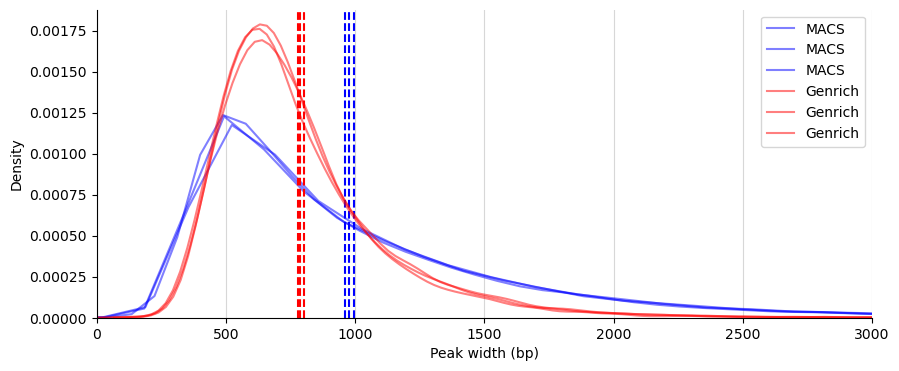

In [49]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in genrich_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="Genrich")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
sns.despine()


# Compare MACS2 and Genrich within biological replicates, where we expect results to be the same
### Calculate the correlation between the fold-difference reported by MACS, and the fold difference calculated from the Genrich pileup at the MACS summit

In [50]:
for m in macs_dfs:
    # convert peak/summit coordinate into an interval to overlap with pyranges
    m['peak_coord_1'] = m['peak_coord'] + 1

# gather relevant columns, put in new list of dataframes
macs_summit_dfs = [m[['Chromosome', 'peak_coord', 'peak_coord_1', 'signalValue']] for m in macs_dfs]

# rename columns to match pyranges format
for m in macs_summit_dfs:
    m.columns = ['Chromosome', 'Start', 'End', 'signalValue']

# convert df to pyranges object
macs_summit_prs = [pr.PyRanges(m) for m in macs_summit_dfs]
pileup_prs = [pr.PyRanges(p) for p in pileup_dfs]

# overlap macs peaks with genrich pileups
macs_with_pileup_dfs = []
for p,m in zip(pileup_prs, macs_summit_prs):
    # if you exclude regions in Genrich, need to do 'inner' join or None
    # previously you doing a right join since without exclude regions, we expected all macs peaks coords 
    # to overlap with a genrich pileup coord
    macs_with_pileup_dfs.append( p.join(m, how=None).df )

# calculate correlation between the MACS fold-difference and 
for m in macs_with_pileup_dfs:
    print(np.corrcoef(m.fold_diff, m.signalValue))



[[1.         0.87538682]
 [0.87538682 1.        ]]
[[1.         0.86794224]
 [0.86794224 1.        ]]
[[1.         0.86438476]
 [0.86438476 1.        ]]


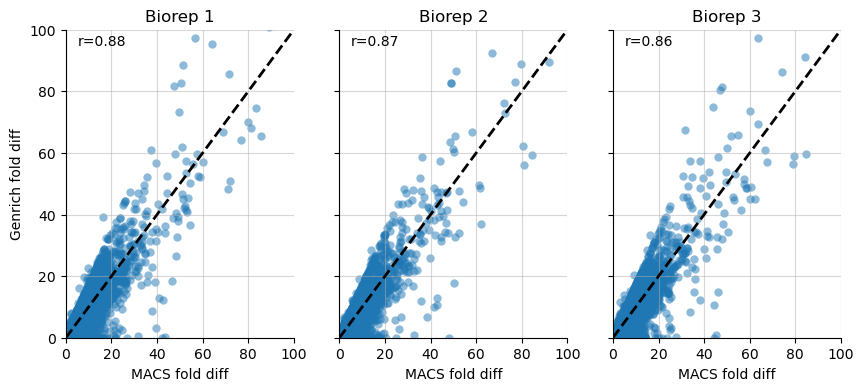

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,m in enumerate(macs_with_pileup_dfs):
    sns.scatterplot(x=m.signalValue, y=m.fold_diff, ax=axs[i], linewidth=0, alpha=0.5)
    axs[i].set_title(f"Biorep {i+1}")
    axs[i].set_xlabel("MACS fold diff")
    axs[i].set_ylabel("Genrich fold diff")    
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(m.fold_diff, m.signalValue)[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)

sns.despine()

# COMPARE PEAKS by overlapping intervals

In [52]:

# look at concordance of peak calling between methods, witihin bioreps
macs_peaks_overlaps, genrich_peaks_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)
for i,m in enumerate(macs_peaks_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_peaks_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# fraction of overlap can seem odd if one caller has smaller peaks that are contained within a larger peak from the other caller

[(42686, 0.198777116619032), (47407, 0.1956462125846394), (42085, 0.2689794463585601)]
[(11454, 0.9929282346778417), (12576, 0.9939567430025446), (15193, 0.9904561311130126)]
MACS2: 42686 peaks, 19.88% overlap with Genrich peaks
MACS2: 47407 peaks, 19.56% overlap with Genrich peaks
MACS2: 42085 peaks, 26.90% overlap with Genrich peaks
Genrich: 11454 peaks, 99.29% overlap with MACS2 peaks
Genrich: 12576 peaks, 99.40% overlap with MACS2 peaks
Genrich: 15193 peaks, 99.05% overlap with MACS2 peaks


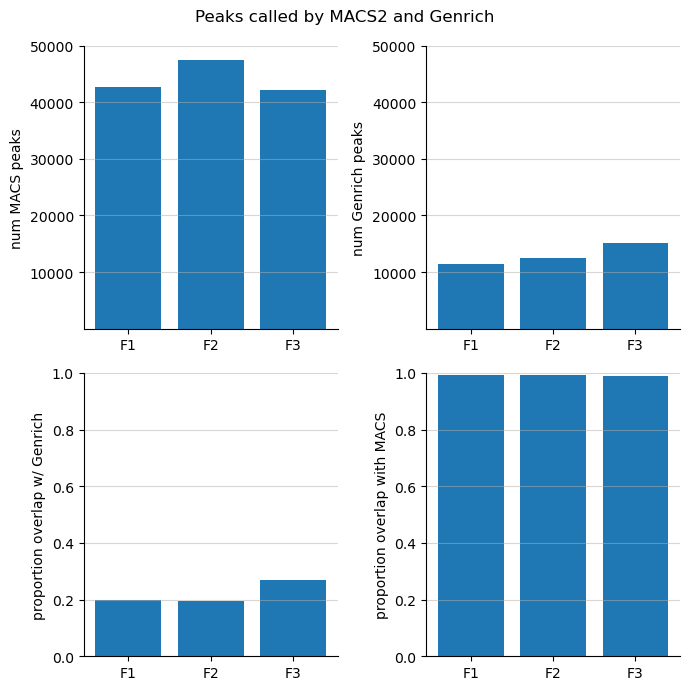

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=False, sharey=False)
t = range(len(macs_peaks_overlaps))
axs[0][0].bar(t, [m[0] for m in macs_peaks_overlaps])
axs[0][0].set_ylabel("num MACS peaks")
axs[0][0].set_xticks(t)
axs[0][0].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][0].set_xticklabels(bioreps)
axs[0][0].grid(axis='y', alpha=0.5)

axs[0][1].bar(t, [g[0] for g in genrich_peaks_overlaps])
axs[0][1].set_ylabel("num Genrich peaks")
axs[0][1].set_xticks(t)
axs[0][1].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][1].set_xticklabels(bioreps)
axs[0][1].grid(axis='y', alpha=0.5)


axs[1][0].bar(t, [m[1] for m in macs_peaks_overlaps])
axs[1][0].set_ylim(0,1)
axs[1][0].set_ylabel("proportion overlap w/ Genrich")
axs[1][0].set_xticks(t)
axs[1][0].set_xticklabels(bioreps)
axs[1][0].grid(axis='y', alpha=0.5)



axs[1][1].bar(t, [g[1] for g in genrich_peaks_overlaps])
axs[1][1].set_ylim(0,1)
axs[1][1].set_ylabel("proportion overlap with MACS")
axs[1][1].set_xticks(t)
axs[1][1].set_xticklabels(bioreps)
axs[1][1].grid(axis='y', alpha=0.5)

fig.suptitle("Peaks called by MACS2 and Genrich")


sns.despine()
plt.tight_layout()

# Compare MACS and Genrich between biological replicates

In [54]:
# look at overlaps within methods between bioreps
macs_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dfs, bioreps, frac_overlap)
genrich_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(genrich_dfs, bioreps, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)

[(42686, 47407, 22073), (42686, 42085, 21381), (47407, 42085, 21415)]
[(11454, 12576, 7334), (11454, 15193, 8125), (12576, 15193, 8090)]


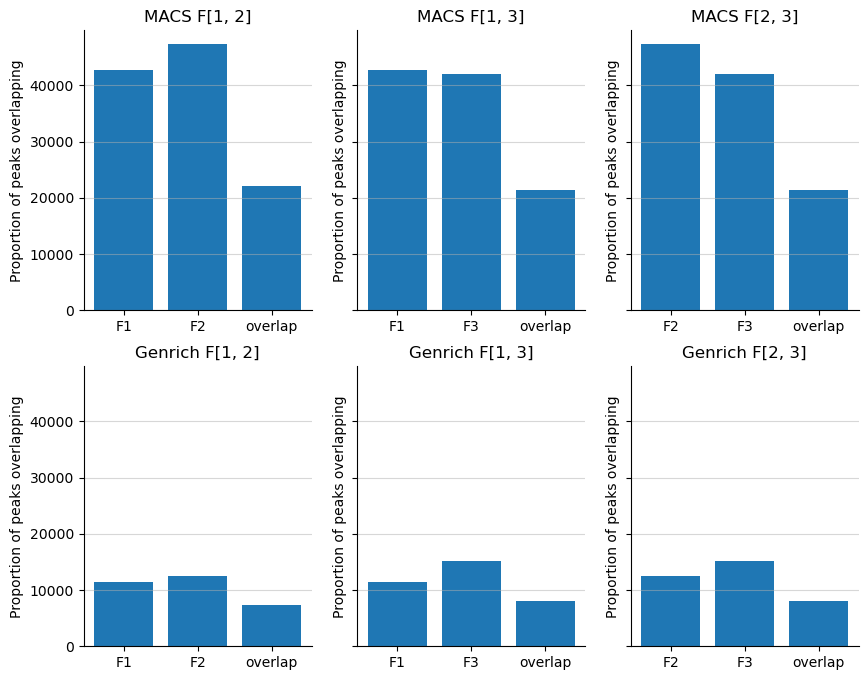

In [55]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

In [56]:
# convert each df to a pyranges object, count overlaps among biological replicates

genrich_overlaps_per_rep = fn.overlaps_per_replicate(genrich_dfs)
macs_overlaps_per_rep = fn.overlaps_per_replicate(macs_dfs)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point

macs_overlaps_per_rep.head()

,Chromosome,Start,End,p1,p2,p3,combined
0,AVIR_chr_1,383230,383300,1,0,0,100
1,AVIR_chr_1,383300,383348,1,0,1,101
2,AVIR_chr_1,383348,383741,1,1,1,111
3,AVIR_chr_1,383741,383770,1,1,0,110
4,AVIR_chr_1,383770,384265,1,0,0,100


In [57]:
genrich_overlaps_per_rep.combined.unique()

array(['010', '000', '001', '111', '011', '101', '110', '100'],
      dtype=object)

In [58]:
def get_triplet_peaks(overlaps_df, min_interval_size, method):
    trips_df = overlaps_df[(overlaps_df['End']-overlaps_df['Start'] > min_interval_size) & 
                            (overlaps_df['combined'] == '111')]                          
    trips_df['method'] = method
    return trips_df
    
genrich_trips_df = get_triplet_peaks(genrich_overlaps_per_rep, min_interval_size, 'genrich')
macs_trips_df = get_triplet_peaks(macs_overlaps_per_rep, min_interval_size, 'macs')

print(len(genrich_trips_df))
print(len(macs_trips_df))

6704
19441


/tmp/ipykernel_601864/728894939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method
/tmp/ipykernel_601864/728894939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method


In [59]:
# make a single dataframe trips_df that contains all Genrich peaks supported by all 3 replicates
# as well as MACS peaks supported by all 3 replicates that were not detected by Genrich

m = pr.PyRanges(chromosomes=macs_trips_df.Chromosome,
                starts=macs_trips_df.Start,
                ends=macs_trips_df.End)
g = pr.PyRanges(chromosomes=genrich_trips_df.Chromosome,
                starts=genrich_trips_df.Start,
                ends=genrich_trips_df.End)
# use coverage to find overlaps, covert to dataframe to filter those with at least frac_overlap overlap
m_cov = m.coverage(g, overlap_col="C", fraction_col="F").df
g_cov = g.coverage(m, overlap_col="C", fraction_col="F").df

# get all indices of m_cov in which 'C' columns == 0, i.e. not detected at all by Genrich
m_cov_indices = m_cov.index[m_cov['C']==0].tolist()
m_cov.iloc[m_cov_indices]
trips_df = pd.concat([genrich_trips_df, macs_trips_df.iloc[m_cov_indices]], axis=0)

trips_df.sort_values(by=['Chromosome', 'Start'], inplace=True)
trips_df = trips_df.reset_index(drop=True)
trips_df['trip_id'] = trips_df.index
print(trips_df.groupby('method').count())
trips_df

         Chromosome  Start    End     p1     p2     p3  combined  trip_id
method                                                                   
genrich        6704   6704   6704   6704   6704   6704      6704     6704
macs          13025  13025  13025  13025  13025  13025     13025    13025


,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id
0,AVIR_chr_1,383348,383741,1,1,1,111,macs,0
1,AVIR_chr_1,384277,384849,1,1,1,111,macs,1
2,AVIR_chr_1,608892,609334,1,1,1,111,genrich,2
3,AVIR_chr_1,623318,623988,1,1,1,111,macs,3
4,AVIR_chr_1,725633,725983,1,1,1,111,macs,4
...,...,...,...,...,...,...,...,...,...
19724,AVIR_chr_9,31017908,31018592,1,1,1,111,macs,19724
19725,AVIR_chr_9,31028727,31029360,1,1,1,111,macs,19725
19726,AVIR_chr_9,31035061,31035457,1,1,1,111,macs,19726
19727,AVIR_chr_9,31065473,31065998,1,1,1,111,macs,19727


14490663
734.4854275432104


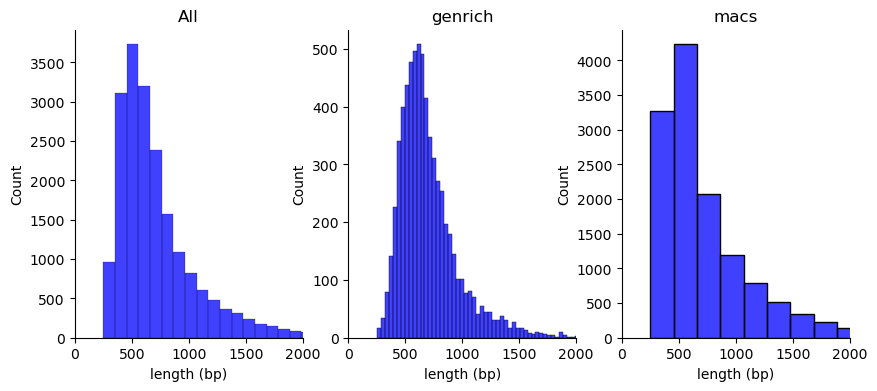

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=False)
print(np.sum(trips_df['End'] - trips_df['Start']))
print(np.mean(trips_df['End'] - trips_df['Start']))

sns.histplot(trips_df['End'] - trips_df['Start'], bins=100, color="blue", ax=axs[0])
axs[0].set_title("All")
axs[0].set_xlabel("length (bp)")
axs[0].set_xlim(0,2000)
sns.histplot(trips_df['End'][trips_df['method']=='genrich'] - trips_df['Start'][trips_df['method']=='genrich'], bins=100, color="blue", ax=axs[1])
axs[1].set_title("genrich")
axs[1].set_xlabel("length (bp)")
sns.histplot(trips_df['End'][trips_df['method']=='macs'] - trips_df['Start'][trips_df['method']=='macs'], bins=50, color="blue", ax=axs[2])
axs[2].set_title("macs")
axs[2].set_xlabel("length (bp)")


sns.despine()

In [61]:
# convert dataframes into pyranges for overlapping
# trips_pr = pr.PyRanges(trips_df.head(10))
trips_pr = pr.PyRanges(trips_df)
pile1 = pr.PyRanges(pileup_dfs[0])
pile2 = pr.PyRanges(pileup_dfs[1])
pile3 = pr.PyRanges(pileup_dfs[2])

pile1_trips = pile1.join(trips_pr, report_overlap=True, how='right')
pile2_trips = pile2.join(trips_pr, report_overlap=True, how='right')
pile3_trips = pile3.join(trips_pr, report_overlap=True, how='right')

pile1_trips = pile1_trips.df
pile2_trips = pile2_trips.df
pile3_trips = pile3_trips.df



In [62]:
print(pile1_trips.shape)
print(pile2_trips.shape)
print(pile3_trips.shape)

(537672, 18)
(528263, 18)
(536839, 18)


In [63]:
# for each trip_id in each replicate, get average fold diff wtihin each interval, weighted by number of bases in pileup
f_wavg = lambda x: np.average(x.fold_diff, weights=x.bases)
f_summit = lambda x: x.midpoint[x.fold_diff == np.max(x.fold_diff)].values[0]

pile1_trips_wavgs = pile1_trips.groupby('trip_id').apply(f_wavg)
pile2_trips_wavgs = pile2_trips.groupby('trip_id').apply(f_wavg)
pile3_trips_wavgs = pile3_trips.groupby('trip_id').apply(f_wavg)
wavg = np.column_stack((pile1_trips_wavgs,
                    pile2_trips_wavgs,
                    pile3_trips_wavgs))

# get the position of the fold_difference summit within each peak within each biological replicate
pile1_trips_summits = pile1_trips.groupby('trip_id').apply(f_summit)
pile2_trips_summits = pile2_trips.groupby('trip_id').apply(f_summit)
pile3_trips_summits = pile3_trips.groupby('trip_id').apply(f_summit)

# filter out rows of wavg with any 0 values
print(np.sum(np.any(wavg == 0, axis=1)), "peaks had at least 1 replicate with 0-fold difference")
print(np.sum(np.any(wavg < 0, axis=1)), "peaks had at least 1 replicate with negative difference")
wavg = wavg[(~np.any(wavg == 0, axis=1)) & (~np.any(wavg < 0, axis=1))]


trips_df["F1_pileup_wavg"] = pile1_trips_wavgs
trips_df["F2_pileup_wavg"] = pile2_trips_wavgs
trips_df["F3_pileup_wavg"] = pile3_trips_wavgs

trips_df["F1_pileup_summit"] = pile1_trips_summits
trips_df["F2_pileup_summit"] = pile2_trips_summits
trips_df["F3_pileup_summit"] = pile3_trips_summits

# compute the average of the fold_difference summits; this will be used to center kmer windows later on
trips_df["mean_pileup_summit"] = trips_df[['F1_pileup_summit', 'F2_pileup_summit', 'F3_pileup_summit']].mean(axis=1)





329 peaks had at least 1 replicate with 0-fold difference
0 peaks had at least 1 replicate with negative difference


In [64]:
# CORRLEATION BETWEEN WEIGHTED AVERAGE FOLD DIFFERENCES WITHIN PEAK ACROSS BIOLOGICAL REPLICATES
print(np.corrcoef(wavg, rowvar=False))


[[1.         0.90693972 0.91265081]
 [0.90693972 1.         0.89873784]
 [0.91265081 0.89873784 1.        ]]


In [65]:
trips_df

,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,F1_pileup_summit,F2_pileup_summit,F3_pileup_summit,mean_pileup_summit
0,AVIR_chr_1,383348,383741,1,1,1,111,macs,0,0.000000,0.000000,0.000000,382361.0,382361.0,382361.0,3.823610e+05
1,AVIR_chr_1,384277,384849,1,1,1,111,macs,1,3.002608,1.493757,1.517578,384571.0,384457.0,384571.0,3.845330e+05
2,AVIR_chr_1,608892,609334,1,1,1,111,genrich,2,4.756909,4.426249,4.660633,609332.0,608918.5,609235.5,6.091620e+05
3,AVIR_chr_1,623318,623988,1,1,1,111,macs,3,4.060317,2.769103,3.244958,623538.5,623799.5,623725.5,6.236878e+05
4,AVIR_chr_1,725633,725983,1,1,1,111,macs,4,3.149137,1.725330,2.232514,725770.0,725677.5,725753.0,7.257335e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19724,AVIR_chr_9,31017908,31018592,1,1,1,111,macs,19724,2.421142,2.190251,3.207179,31018287.0,31018287.0,31018336.5,3.101830e+07
19725,AVIR_chr_9,31028727,31029360,1,1,1,111,macs,19725,2.431146,2.130405,1.754866,31029334.0,31028936.0,31029118.0,3.102913e+07
19726,AVIR_chr_9,31035061,31035457,1,1,1,111,macs,19726,2.919857,3.393878,2.406602,31035077.0,31035203.5,31035099.0,3.103513e+07
19727,AVIR_chr_9,31065473,31065998,1,1,1,111,macs,19727,1.242952,1.344129,0.795560,31065978.0,31065528.5,31065978.0,3.106583e+07


# Make BED file for HOMER to look for TFBS enrichment

In [66]:
# min_fold_diff = 3
# homer_df = trips_df[(trips_df['F1_pileup_wavg'] > min_fold_diff)
#                     & (trips_df['F2_pileup_wavg'] > min_fold_diff)
#                     & (trips_df['F3_pileup_wavg'] > min_fold_diff)]

max_fold_diff = 1.8
homer_df = trips_df[(trips_df['F1_pileup_wavg'] < max_fold_diff)
                    & (trips_df['F2_pileup_wavg'] < max_fold_diff)
                    & (trips_df['F3_pileup_wavg'] < max_fold_diff)]

homer_df = homer_df[['Chromosome', 'Start', 'End', 'trip_id', 'method']]
# add a column to homer_df that is all '+' using .loc method
homer_df.loc[:, 'Strand'] = '+'

print(len(homer_df))
# d = f'/Users/bjarnold/Princeton_EEB/Kocher/STARRseq/homer_test/{species}'
# print homer_df as tab separated file
# homer_df.to_csv(f'{d}/max1.8fold_regions.txt', sep='\t', index=False, header=False)

1467


# Make Kmers

In [67]:
def get_win(position, kmer_size):
    lower = position - int(kmer_size/2)
    upper = position + int(kmer_size/2) + 1
    return [lower, upper]

kmers = defaultdict(list)

kid = 0
for i,row in trips_df.iterrows():
    chrom, summit, tid = row['Chromosome'], int(row['mean_pileup_summit']), row['trip_id']
    k = get_win(summit, kmer_size)
    if (k[0] >= 0) and (k[1] <= scaff_lengths[chrom]):
        kmers['Chromosome'].append(chrom)
        kmers['Start'].append( k[0] )
        kmers['End'].append( k[1] )
        kmers['trip_peak_id'].append(tid)

    step=1
    k = get_win(summit - step_size*step, kmer_size)
    while ((row['Start'] - k[0]) <= overhang_thresh) and (k[0] >= 0) and (k[1] <= scaff_lengths[chrom]):
        kmers['Chromosome'].append(chrom)
        kmers['Start'].append( k[0] )
        kmers['End'].append( k[1] )
        kmers['trip_peak_id'].append(tid)
        step += 1
        k = get_win(summit - step_size*step, kmer_size)

    step=1
    k = get_win(summit + step_size*step, kmer_size)
    while ((k[1] - row['End']) <= overhang_thresh) and (k[0] >= 0) and (k[1] <= scaff_lengths[chrom]):
        kmers['Chromosome'].append(chrom)
        kmers['Start'].append( k[0] )
        kmers['End'].append( k[1] )
        kmers['trip_peak_id'].append(tid)
        step += 1
        k = get_win(summit + step_size*step, kmer_size)


kmer_df = pd.DataFrame.from_dict(kmers)
kmer_df['kmer_id'] = kmer_df.index
assert (kmer_df['End'] - kmer_df['Start']).unique()[0] == kmer_size



In [68]:
kmer_df[kmer_df['trip_peak_id']==0]

,Chromosome,Start,End,trip_peak_id,kmer_id
0,AVIR_chr_1,382237,382486,0,0
1,AVIR_chr_1,382337,382586,0,1
2,AVIR_chr_1,382437,382686,0,2
3,AVIR_chr_1,382537,382786,0,3
4,AVIR_chr_1,382637,382886,0,4
5,AVIR_chr_1,382737,382986,0,5
6,AVIR_chr_1,382837,383086,0,6
7,AVIR_chr_1,382937,383186,0,7
8,AVIR_chr_1,383037,383286,0,8
9,AVIR_chr_1,383137,383386,0,9


In [69]:
# overlap kmer windows with pileup to calculate the average fold difference within each kmer window, weights by the intervals in the pileup file
kmer_pr = pr.PyRanges(kmer_df)
pile1_kmers = pile1.join(kmer_pr, report_overlap=True, how='right').df
pile2_kmers = pile2.join(kmer_pr, report_overlap=True, how='right').df
pile3_kmers = pile3.join(kmer_pr, report_overlap=True, how='right').df

pile2_kmers.head(30)



,Chromosome,Start,End,bases,midpoint,experimental,control,fold_diff,-log(p),Start_b,End_b,trip_peak_id,kmer_id,Overlap
0,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382237,382486,0,0,249
1,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382337,382586,0,1,249
2,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382437,382686,0,2,249
3,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382537,382786,0,3,249
4,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382637,382886,0,4,249
5,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382737,382986,0,5,249
6,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382837,383086,0,6,249
7,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,382937,383186,0,7,249
8,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,383037,383286,0,8,249
9,AVIR_chr_1,380457,384265,3808,382361.0,0.0,22.225794,0.000000,0.000000,383137,383386,0,9,249


In [70]:
f_wavg = lambda x: np.average(x.fold_diff, weights=x.Overlap) # make sure to weight by overlap, not 'bases' which comes from the original pileup

pile1_kmers_wavgs = pile1_kmers.groupby('kmer_id').apply(f_wavg)
pile2_kmers_wavgs = pile2_kmers.groupby('kmer_id').apply(f_wavg)
pile3_kmers_wavgs = pile3_kmers.groupby('kmer_id').apply(f_wavg)

kmer_df["F1_pileup_wavg"] = pile1_kmers_wavgs
kmer_df["F2_pileup_wavg"] = pile2_kmers_wavgs
kmer_df["F3_pileup_wavg"] = pile3_kmers_wavgs

print(np.corrcoef(kmer_df[['F1_pileup_wavg', 'F2_pileup_wavg', 'F3_pileup_wavg']], rowvar=False))

kmer_df["median_pileup_wavg"] = kmer_df[['F1_pileup_wavg', 'F2_pileup_wavg', 'F3_pileup_wavg']].median(axis=1)
kmer_df['sequence'] = pr.get_sequence(pr.PyRanges(kmer_df), ref_genome)

kmer_df[['Chromosome','Start','End','sequence']].to_csv(f'./kmers_test.txt', sep='\t', index=False, header=False)    

[[1.         0.92003285 0.92274714]
 [0.92003285 1.         0.91449624]
 [0.92274714 0.91449624 1.        ]]


In [29]:
kmer_df[kmer_df['Chromosome'] == 'NMEL_unplaced_782'].head()

,Chromosome,Start,End,trip_peak_id,kmer_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,median_pileup_wavg,sequence
97600,NMEL_unplaced_782,404,653,22908,97600,68.835936,55.828069,47.567939,55.828069,TCAAAGCCATAAGGCCGAGAAGCGATCTGGATGAGTGTTATGCGAG...
97601,NMEL_unplaced_782,304,553,22908,97601,66.878453,49.265793,44.408047,49.265793,AGTACAATTTGATGTTAGCCATAAGGCTGATGAGCGATCTGGCTGG...
97602,NMEL_unplaced_782,204,453,22908,97602,60.774611,46.196429,38.611653,46.196429,AGGGTTATTGGAGTACACGCTAATCTTAGGCATGAGGCCGAGGAGC...
97603,NMEL_unplaced_782,104,353,22908,97603,44.732293,36.935605,30.367362,36.935605,TTGTGTTAATATTTTATATAACGCCGCACTTACAAAGAATATTTGA...
97604,NMEL_unplaced_782,4,253,22908,97604,22.380265,20.950553,16.862471,20.950553,AATCGAAATACAGACTCGATCCTGTTGCTGAATTCGATGAGCGCCT...


In [30]:
print(kmer_df.head(15)['trip_peak_id'])
print(len(kmer_df['trip_peak_id'].unique()))

0     0
1     0
2     0
3     0
4     1
5     1
6     1
7     1
8     2
9     2
10    3
11    3
12    4
13    4
14    5
Name: trip_peak_id, dtype: int64
22970


<Axes: xlabel='count', ylabel='Count'>

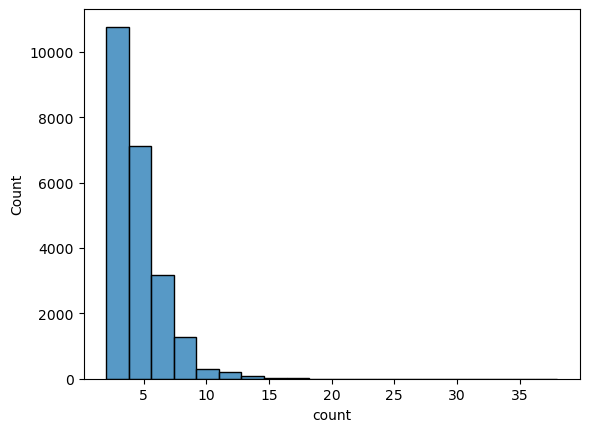

In [31]:
sns.histplot(kmer_df['trip_peak_id'].value_counts(), bins=20)

In [32]:
for i,r in kmer_df.iterrows():
    assert len(r['sequence']) == kmer_size


/Genomics/argo/users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.021108421923347935
1.3044686609663705
1.0772459204813503


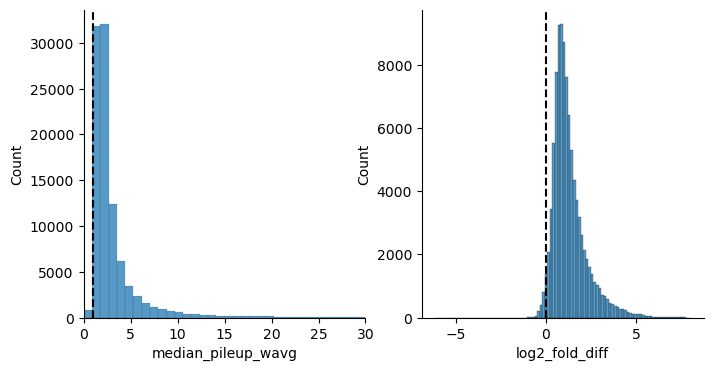

In [33]:
# make a log2 fold difference column from the median_pileup_wavg column
kmer_df['log2_fold_diff'] = np.log2(kmer_df['median_pileup_wavg'])

fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.histplot(kmer_df['median_pileup_wavg'], bins=300, ax=axs[0])
axs[0].set_xlim(0,30)
sns.histplot(kmer_df['log2_fold_diff'], bins=100, ax=axs[1])
axs[0].axvline(x=1, color="black", linestyle='--')
axs[1].axvline(x=0, color="black", linestyle='--')
# filter out rows with NA's or inf in the log2_fold_diff column
kmer_df = kmer_df[~kmer_df['log2_fold_diff'].isna()]
kmer_df = kmer_df[~np.isinf(kmer_df['log2_fold_diff'])]
print(len(kmer_df[kmer_df['log2_fold_diff'] <=0])/len(kmer_df))
print(kmer_df['log2_fold_diff'].mean())
print(kmer_df['log2_fold_diff'].median())

sns.despine()

In [34]:
# check for nan in kmer_df['log2_fold_diff'] column
print(np.sum(np.isnan(kmer_df['log2_fold_diff'])))
# check for inf in kmer_df['log2_fold_diff'] column
print(np.sum(np.isinf(kmer_df['log2_fold_diff'])))
# find row indices of inf values
print(np.where(np.isinf(kmer_df['log2_fold_diff'])))


0
0
(array([], dtype=int64),)


In [35]:
def split_dataframe(df, id_column, train_frac=0.7, validate_frac=0.15, random_state=None):
    # Ensure fractions are correct
    test_frac = 1 - train_frac - validate_frac
    if test_frac < 0:
        raise ValueError("The sum of train_frac and validate_frac should be less than 1")

    # Get unique ids
    unique_ids = df[id_column].unique()
    
    # Split ids for training and temp (validation + test) sets
    train_ids, temp_ids = train_test_split(unique_ids, test_size=(1 - train_frac), random_state=random_state)
    
    # Split temp ids into validation and test sets
    validate_ids, test_ids = train_test_split(temp_ids, test_size=(test_frac / (validate_frac + test_frac)), random_state=random_state)
    
    # Collect rows for each set
    train = df[df[id_column].isin(train_ids)]
    validate = df[df[id_column].isin(validate_ids)]
    test = df[df[id_column].isin(test_ids)]

    return train, validate, test

kmer_train_df, kmer_val_df, kmer_test_df = split_dataframe(kmer_df, 'trip_peak_id')

In [36]:
# double check that data splits have no overlapping tripelt peak ids
train_ids = set(kmer_train_df['trip_peak_id'].unique())
validate_ids = set(kmer_val_df['trip_peak_id'].unique())
test_ids = set(kmer_test_df['trip_peak_id'].unique())

# [validate_ids.add(i) for i in [0,1,2,3,4,5]]

train_validate_overlap = train_ids.intersection(validate_ids)
train_test_overlap = train_ids.intersection(test_ids)
validate_test_overlap = validate_ids.intersection(test_ids)

print("trip_peak_ids")
print(train_validate_overlap, train_test_overlap, validate_test_overlap)
tot = len(train_ids) + len(validate_ids) + len(test_ids)
print(len(train_ids), len(validate_ids), len(test_ids))
print(len(train_ids)/tot, len(validate_ids)/tot, len(test_ids)/tot)

print("kmer_ids")
tot = len(kmer_train_df) + len(kmer_val_df) + len(kmer_test_df)
print(len(kmer_train_df), len(kmer_val_df), len(kmer_test_df))
print(len(kmer_train_df)/tot, len(kmer_val_df)/tot, len(kmer_test_df)/tot)

trip_peak_ids
set() set() set()
16078 3445 3447
0.6999564649542882 0.1499782324771441 0.1500653025685677
kmer_ids
68520 14749 14654
0.6997334640482828 0.15061834298377297 0.1496481929679442


# Normalize log enrichment (is this appropriate? deepstarr doesn't do it?)

In [37]:
print(len(kmer_train_df['log2_fold_diff']))
print(len(pd.concat([kmer_train_df['log2_fold_diff'], kmer_val_df['log2_fold_diff']])))

68520
83269


In [38]:
# # normalize fold diffs using only mean and standard deviation from the training and validation set
# mu = pd.concat([kmer_train_df['log2_fold_diff'], kmer_val_df['log2_fold_diff']]).mean()
# std = pd.concat([kmer_train_df['log2_fold_diff'], kmer_val_df['log2_fold_diff']]).std()

# print(mu, std)

# kmer_train_df['log2_fold_diff_scaled'] = (kmer_train_df['log2_fold_diff'] - mu) / std
# kmer_val_df['log2_fold_diff_scaled'] = (kmer_val_df['log2_fold_diff'] - mu) / std
# kmer_test_df['log2_fold_diff_scaled'] = (kmer_test_df['log2_fold_diff'] - mu) / std


In [39]:
# # if data rescaled, should be perfectly correlated with original
# print(np.corrcoef(kmer_train_df[['log2_fold_diff', 'log2_fold_diff_scaled']], rowvar=False))
# fig, axs = plt.subplots(figsize=(3, 3))
# sns.histplot(kmer_train_df['log2_fold_diff_scaled'], bins=100)


In [40]:
# augment the dataset with reverse complement sequences
def get_reverse_complement(dna_sequence):
    seq_obj = Seq(dna_sequence)
    return str(seq_obj.reverse_complement())

def append_reverse_complement(df):
    rc_df = df.copy()
    rc_df['sequence'] = rc_df['sequence'].apply(get_reverse_complement)
    return pd.concat([df, rc_df], axis=0)

# make copy of kmer_df, reverse complement the sequence column, then append to kmer_df
# kmer_rc_df = kmer_df.copy()
# kmer_rc_df['sequence'] = kmer_rc_df['sequence'].apply(get_reverse_complement)
# kmer_df = pd.concat([kmer_df, kmer_rc_df], axis=0)





# kmer_train_df = append_reverse_complement(kmer_train_df)
# kmer_val_df = append_reverse_complement(kmer_val_df)
# kmer_test_df = append_reverse_complement(kmer_test_df)


In [41]:
print(len(kmer_train_df['log2_fold_diff']))
print(len(kmer_val_df['log2_fold_diff']))
print(len(kmer_test_df['log2_fold_diff']))



68520
14749
14654


In [42]:
# write training, validation, and testing to files
d = f'/Genomics/kocherlab/bjarnold/STARRseq/data/meme_suite/sea_output/{species}/OLD_DEEPSTARR_TRAINING_DATA'
# make directory if it doesn't exist
if not os.path.exists(d):
    os.makedirs(d)
# write to fasta file
def write_fasta(df, set_name):
    with open(f"{d}/{set_name}.fa", 'w') as f:
        for i,r in df.iterrows():
            name = r['Chromosome'] + "_" + str(r['Start']) + "_" + str(r['End']) + "_" + str(r['trip_peak_id']) + "_" + str(r['kmer_id'])
            f.write(f">{name}\n{r['sequence']}\n")

write_fasta(kmer_train_df, 'train')
write_fasta(kmer_val_df, 'val')
write_fasta(kmer_test_df, 'test')

def write_enrichment(df, set_name):
    with open(f"{d}/{set_name}.txt", 'w') as f:
        # f.write('log2_fold_diff_scaled\n')
        f.write('log2_fold_diff\n')
        for i,r in df.iterrows():
            # f.write(f"{r['log2_fold_diff_scaled']}\n")
            f.write(f"{r['log2_fold_diff']}\n")

write_enrichment(kmer_train_df, 'train')
write_enrichment(kmer_val_df, 'val')
write_enrichment(kmer_test_df, 'test')


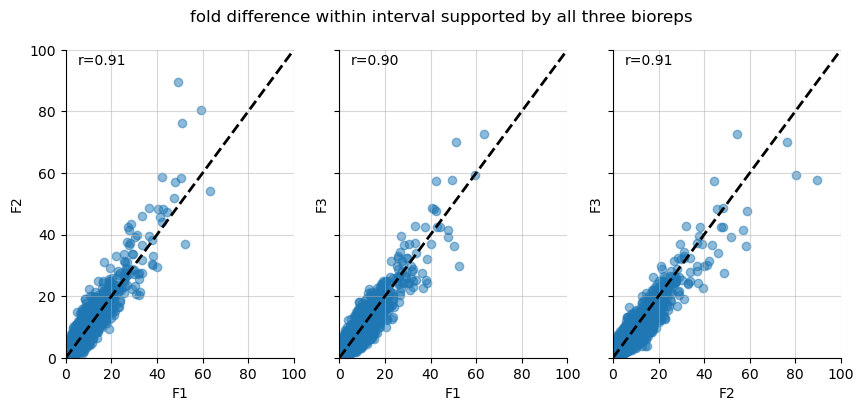

In [ ]:
combos = list(itertools.combinations(range(wavg.shape[1]), 2))
combos

fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,combo in enumerate(combos):
    axs[i].scatter(wavg[:,combo[0]], wavg[:,combo[1]], alpha=0.5)
    axs[i].set_xlabel(f"F{combo[0]+1}")
    axs[i].set_ylabel(f"F{combo[1]+1}")
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(wavg[:,combo[0]], wavg[:,combo[1]])[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)
fig.suptitle("fold difference within interval supported by all three bioreps")
sns.despine()

# look at fold differences within each biological replicate; any systematic differences?

medians: [2.7815356  2.80448837 2.74557206]
means: [3.53154327 3.6721629  3.495693  ]
variances: [ 9.0862498  11.21108771  8.95443601]
means of logged: [0.45843807 0.46895063 0.4545409 ]
variances of logged: [0.08215785 0.08586797 0.08211291]


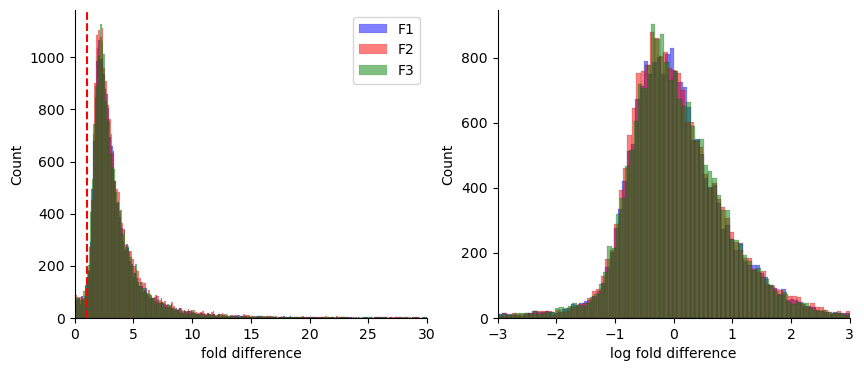

In [ ]:
# are there systematic differences in fold differences across replicates?
print("medians:", np.median(wavg, axis=0))
print("means:", np.mean(wavg, axis=0))
print("variances:", np.var(wavg, axis=0))
print("means of logged:", np.mean(np.log10(wavg), axis=0))
print("variances of logged:", np.var(np.log10(wavg), axis=0))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(wavg[:,0], color="blue", alpha=0.5, label="F1", ax=axs[0])
sns.histplot(wavg[:,1], color="red", alpha=0.5, label="F2", ax=axs[0])
sns.histplot(wavg[:,2], color="green", alpha=0.5, label="F3", ax=axs[0])
axs[0].axvline(x=1, color='red', linestyle='--')
axs[0].set_xlim(0,30)
axs[0].set_xlabel("fold difference")
axs[0].legend()

wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / np.std(np.log10(wavg), axis=0)
# wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / (np.max(np.log10(wavg), axis=0) - np.min(np.log10(wavg), axis=0))

# wavg_norm = (wavg - np.mean(wavg, axis=0)) / np.std(wavg, axis=0)

sns.histplot((wavg_norm[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
sns.histplot((wavg_norm[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
sns.histplot((wavg_norm[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
# sns.histplot(np.log10(wavg[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
# sns.histplot(np.log10(wavg[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
# sns.histplot(np.log10(wavg[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
axs[1].set_xlim(-3,3)
axs[1].set_xlabel("log fold difference")

sns.despine()


# look at specific triplet interval

   Chromosome   Start     End p1 p2 p3 combined   method trip_id  \
2  AVIR_chr_1  608892  609334  1  1  1      111  genrich       2   

  F1_pileup_wavg F2_pileup_wavg F3_pileup_wavg F1_pileup_summit  \
2       4.660633       4.756909       4.426249         609235.5   

  F2_pileup_summit F3_pileup_summit mean_pileup_summit  
2         609332.0         608918.5           609162.0  
    Chromosome   Start     End  trip_peak_id  kmer_id  F1_pileup_wavg  \
19  AVIR_chr_1  609038  609287             2       19        4.898166   
20  AVIR_chr_1  608938  609187             2       20        4.661541   
21  AVIR_chr_1  608838  609087             2       21        3.708461   
22  AVIR_chr_1  609138  609387             2       22        4.277190   

    F2_pileup_wavg  F3_pileup_wavg  median_pileup_wavg  \
19        4.782443        4.194549            4.782443   
20        4.662786        4.536010            4.661541   
21        3.685809        4.212270            3.708461   
22        4.1667

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_12825/216481191.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.axvline(x=int(tmp.mean_pileup_summit), color='black', linestyle='-', linewidth=5)


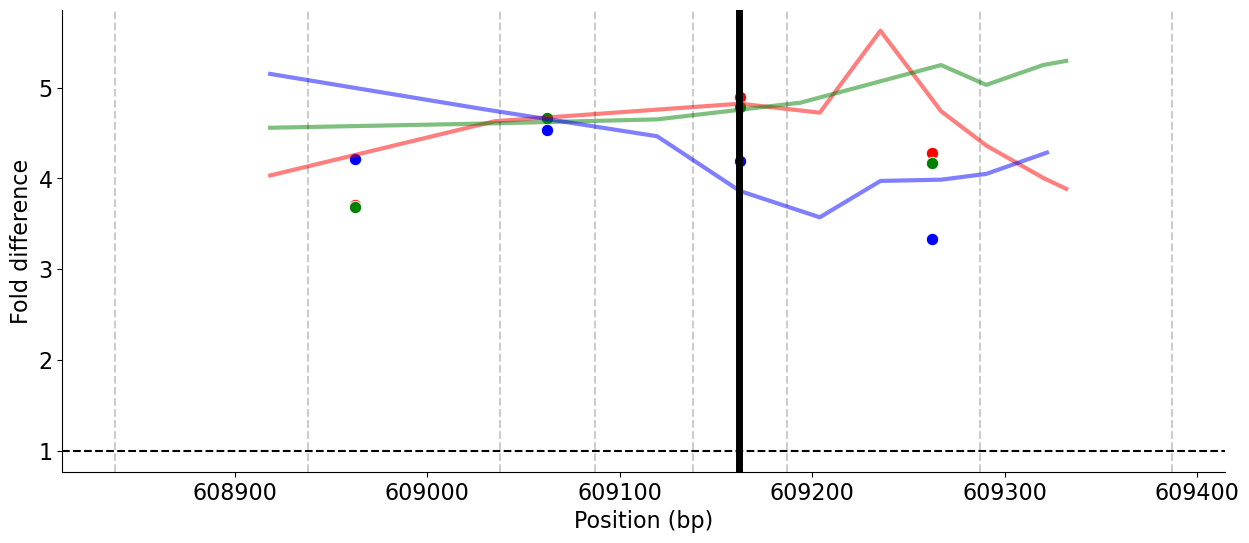

In [ ]:
# NOTE: USED MACS THRESHOLD OF FOLD DIFFERENCE, BUT REPORTED FOLD DIFFERENCE REPORTED HERE IS FROM GENRICH SO COULD BE DIFFERENT
i = 2
tmp = pd.DataFrame(trips_df.iloc[i]).T
print(tmp)

kmer_tmp = kmer_df[kmer_df['trip_peak_id'] == tmp.trip_id.iloc[0]]
print(kmer_tmp)


candidate_trip_pr = pr.PyRanges(chromosomes=tmp.Chromosome,
                starts=tmp.Start,
                ends=tmp.End)

fig, axs = plt.subplots(1, 1, figsize=(15, 6), sharex=True)
colors = ['red', 'green', 'blue']
for i,p in enumerate([pile1, pile2, pile3]):
    candidate_trip_pile = candidate_trip_pr.join(p, report_overlap=True, how='left')
    sns.lineplot(x=candidate_trip_pile.midpoint, y=candidate_trip_pile.fold_diff, linewidth=3, alpha=0.5, color=colors[i])

# sanity check that the weighted avg fold differences within kmer windows resemble pileup raw values
sns.scatterplot(x=(kmer_tmp.End-kmer_tmp.Start)/2 + kmer_tmp.Start, y=kmer_tmp.F1_pileup_wavg, color=colors[0], s=80, alpha=1)
sns.scatterplot(x=(kmer_tmp.End-kmer_tmp.Start)/2 + kmer_tmp.Start, y=kmer_tmp.F2_pileup_wavg, color=colors[1], s=80, alpha=1)
sns.scatterplot(x=(kmer_tmp.End-kmer_tmp.Start)/2 + kmer_tmp.Start, y=kmer_tmp.F3_pileup_wavg, color=colors[2], s=80, alpha=1)

# plt.axhline(y=tmp.F1_pileup_wavg.iloc[0], color=colors[0], linestyle='--')
# plt.axhline(y=tmp.F2_pileup_wavg.iloc[0], color=colors[1], linestyle='--')
# plt.axhline(y=tmp.F3_pileup_wavg.iloc[0], color=colors[2], linestyle='--')

# plt.axvline(x=tmp.F1_pileup_summit.iloc[0], color=colors[0], linestyle='--')
# plt.axvline(x=tmp.F2_pileup_summit.iloc[0], color=colors[1], linestyle='--')
# plt.axvline(x=tmp.F3_pileup_summit.iloc[0], color=colors[2], linestyle='--')

# sanity check that kmers sample intervals correctly
plt.axvline(x=int(tmp.mean_pileup_summit), color='black', linestyle='-', linewidth=5)
for i,r in kmer_tmp.iterrows():
    plt.axvline(x=r.Start, color='black', linestyle='--', alpha=0.2)
    plt.axvline(x=r.End, color='black', linestyle='--', alpha=0.2)

# increase font sizes
axs.set_xlabel("Position (bp)", fontsize=16)
axs.set_ylabel("Fold difference", fontsize=16)
# increase x and y axes font size
axs.tick_params(axis='both', which='major', labelsize=16)
plt.axhline(y=1, color='black', linestyle='--')
sns.despine()


In [ ]:
kmer_df

,Chromosome,Start,End,trip_peak_id,kmer_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,median_pileup_wavg,sequence,log2_fold_diff
14,AVIR_chr_1,384409,384658,1,14,2.021939,3.928990,1.990460,2.021939,TTTGCATGCACAATCATCACACACATACACTCTTTTGAACGAAGTC...,1.015739
15,AVIR_chr_1,384309,384558,1,15,1.410432,2.486548,1.592503,1.592503,ATTGTATATAGATTCAAACCCACACCGTACATCGTAATCTGTATAT...,0.671296
16,AVIR_chr_1,384209,384458,1,16,0.663568,0.921129,0.947739,0.921129,CTCACCAAAATATGTATCCTGCCAATGGATCAAGACATAGAAGTTC...,-0.118525
17,AVIR_chr_1,384509,384758,1,17,1.904431,3.961907,1.699185,1.904431,GAATCGAAACTTCTAGAAAATATCGATCGGTCCAAAACCGGTTTTA...,0.929360
18,AVIR_chr_1,384609,384858,1,18,1.606941,3.600002,1.316406,1.606941,TATCGATCGGCTAAAACAATTGGTAGCGAAGCGGTTTTCCCGCGTC...,0.684317
...,...,...,...,...,...,...,...,...,...,...,...
159767,AVIR_chr_9,31068567,31068816,19730,159767,1.972892,2.057184,2.166648,2.057184,GTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGT...,1.040671
159768,AVIR_chr_9,31068467,31068716,19730,159768,2.120350,2.005207,2.084586,2.084586,GGTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGG...,1.059761
159769,AVIR_chr_9,31069167,31069416,19730,159769,3.889981,4.583618,2.178088,3.889981,TGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTG...,1.959763
159770,AVIR_chr_9,31069267,31069516,19730,159770,3.943051,4.645935,2.140556,3.943051,GGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTGGGTTAGGTCTGG...,1.979312


In [ ]:
kmer_chr1_df = kmer_df[kmer_df['Chromosome'] == 'NMEL_chr_1']
len(kmer_chr1_df)

0

In [ ]:

gibbs, tm = [], []
for i,r in kmer_chr1_df.iterrows():
    # if i <= 10000:
    result = primer3.calcHomodimer(r['sequence'])
    gibbs.append(result.dg)
    tm.append(result.tm)
    # print(primer3.calcHomodimer(r['sequence']))

In [ ]:
print(len(kmer_chr1_df))
print(len(gibbs))
print(len(tm))

0
0
0


In [ ]:
kmer_chr1_df['gibbs'] = gibbs
kmer_chr1_df['tm'] = tm
kmer_chr1_df

,Chromosome,Start,End,trip_peak_id,kmer_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,median_pileup_wavg,sequence,log2_fold_diff,gibbs,tm


[[nan nan]
 [nan nan]]


/Users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bjarnold/miniforge3/envs/pyranges/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


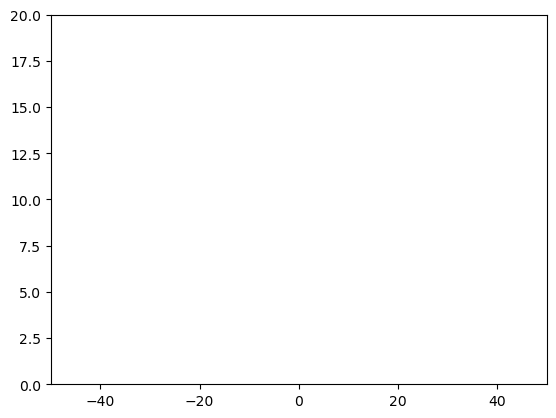

In [ ]:
sns.scatterplot(x=kmer_chr1_df['tm'], y=kmer_chr1_df['median_pileup_wavg'], linewidth=0, alpha=0.1)
plt.xlim(-50,50)
plt.ylim(0,20)
print(np.corrcoef(kmer_chr1_df['tm'], kmer_chr1_df['median_pileup_wavg']))

In [ ]:
trips_df.head(20)

,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,F1_pileup_summit,F2_pileup_summit,F3_pileup_summit,mean_pileup_summit
0,AVIR_chr_1,383348,383741,1,1,1,111,macs,0,0.000000,0.000000,0.000000,382361.0,382361.0,382361.0,3.823610e+05
1,AVIR_chr_1,384277,384849,1,1,1,111,macs,1,1.517578,3.002608,1.493757,384571.0,384571.0,384457.0,3.845330e+05
2,AVIR_chr_1,608892,609334,1,1,1,111,genrich,2,4.660633,4.756909,4.426249,609235.5,609332.0,608918.5,6.091620e+05
3,AVIR_chr_1,623318,623988,1,1,1,111,macs,3,3.244958,4.060317,2.769103,623725.5,623538.5,623799.5,6.236878e+05
4,AVIR_chr_1,725633,725983,1,1,1,111,macs,4,2.232514,3.149137,1.725330,725753.0,725770.0,725677.5,7.257335e+05
5,AVIR_chr_1,744680,745465,1,1,1,111,genrich,5,23.959640,21.989356,16.450050,745076.5,745089.5,745134.5,7.451002e+05
6,AVIR_chr_1,749743,750478,1,1,1,111,macs,6,3.096346,1.694779,2.480099,750044.5,750038.5,750056.5,7.500465e+05
7,AVIR_chr_1,775010,775512,1,1,1,111,macs,7,1.902271,0.866888,0.815494,775186.0,775488.5,775397.5,7.753573e+05
8,AVIR_chr_1,821732,822358,1,1,1,111,genrich,8,4.820792,4.333784,3.828603,822016.0,822045.0,821850.5,8.219705e+05
9,AVIR_chr_1,868941,869299,1,1,1,111,macs,9,3.362951,5.589538,3.767130,869293.0,869243.5,869061.0,8.691992e+05


In [ ]:
# for each peak, find summit within each biological replicate


In [ ]:
tmp = pd.DataFrame(trips_df.iloc[0])
# transspose x so that row names are column names
tmp = tmp.T
tmp

,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id,F1_pileup_wavg,F2_pileup_wavg,F3_pileup_wavg,F1_pileup_summit,F2_pileup_summit,F3_pileup_summit,mean_pileup_summit
0,AVIR_chr_1,383348,383741,1,1,1,111,macs,0,0.0,0.0,0.0,382361.0,382361.0,382361.0,382361.0


In [ ]:
candidate_trip_df[candidate_trip_df['combined'] == '111']
#  df = df[df['combined'].isin(support_patterns)]

NameError: name 'candidate_trip_df' is not defined

In [ ]:
num_points = 833/100
833/num_points

100.0

: 

: 

In [ ]:
stop

NameError: name 'stop' is not defined

: 

: 

# APPENDIX

In [ ]:
# THIS SECTION IS A LITTLE COMPLICATED AND MAY BE REPLACED BY A FUNCTION THAT SIMPLY IDENTIFIES INTERVALS WITH PEAKS SUPPORTED BY 1, 2, OR 3 REPLICATES
# CURRENTLY IT USES INTERVALS WITH NO PEAKS AS LANDMARKS TO IDENTIFY INTERVALS WITH PEAKS SUPPORTED BY 1, 2, OR 3 REPLICATES, BECAUSE I WAS ORIGINALLY 
# THINKING OF USING THESE ENTIRE META INTERVALS IF THEY CONTAINED AT LEAST ONE SUBINTERVAL WITH SUPPORT FROM 3 REPLICATES.

def check_singleton(candidate):
    x = ['100', '010', '001']
    string = candidate['combined'].to_string(index=False)
    try:
        # return index of matching string
        return x.index(string)
    except ValueError:
        return -1

def categorize_support_from_overlaps_df(overlaps_per_rep):
    """
    This function goes through overlaps_per_rep, finds intervals with no peaks, and uses these intervals as landmarks.
    Between these intervals with no peaks are intervals with peaks supported by 1, 2, or 3 replicates, where support 
    can vary. intervals_with_triplet_peaks contains intervals with peaks supported by 3 replicates.
    """

    singleton_peaks = defaultdict(int) # peaks only supported by a single caller
    doublet_peaks = [] # peaks supported by 2 callers with some interval overlap
    intervals_with_triplet_peaks = [] # peaks supported by 3 callers with some interval overlap
    adjacent_nonoverlapping_peaks = 0
    for chrom in overlaps_per_rep['Chromosome'].unique():
        # look only at specific chromosomes to avoid comparing comparing peak callers at chromosome endpoints
        df = overlaps_per_rep[overlaps_per_rep['Chromosome'] == chrom]
        df.reset_index(inplace=True, drop=False) # keep index in case useful for later
        # get candidate intervals using indices in which there's an interval with no peaks
        # these can then be parsed into intervals supported by 1, 2, or 3 replicates
        indices = np.array(df.index[df['combined'] == '000'])
        # print(indices)
        
        for i in range(len(indices)-1):
            # first deal with singleton regions, or single intervals flanked by regions of no peaks
            if indices[i+1] - indices[i] == 2:
                # candidate singleton, a 100, 010, or 001 flanked by 000
                candidate_singleton = df.iloc[[indices[i]+1]]
                singleton_type = check_singleton(candidate_singleton)
                if singleton_type != -1:
                    singleton_peaks[singleton_type] += 1
                else:
                    support_patterns = candidate_singleton['combined'].unique()
                    if '111' in support_patterns:
                        intervals_with_triplet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])
                    elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                        doublet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])  
                    else:
                        print('candidate singleton error')      
            # second deal with larger candidate regions, containing intervals with support from 2+ replicates
            # although rarely, some of these regions contain intervals with only support from 1 replicate with
            # immediately adjacent endpoints
            elif indices[i+1] - indices[i] > 2:
                #multiple intervals involving more than 1 bioreplicate
                candidate_interval_df = df.iloc[list(range(indices[i]+1,indices[i+1]))]
                support_patterns = candidate_interval_df['combined'].unique()
                if '111' in support_patterns:
                    intervals_with_triplet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                    doublet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                else:
                    adjacent_nonoverlapping_peaks += 1
            else:
                print("error")
    print("adjacent_nonoverlapping_peaks: ", adjacent_nonoverlapping_peaks)
    return singleton_peaks, doublet_peaks, intervals_with_triplet_peaks

intervals_with_triplet_peaks = defaultdict(list)
singleton_peaks, doublet_peaks, intervals_with_triplet_peaks['genrich'] = categorize_support_from_overlaps_df(genrich_overlaps_per_rep)
singleton_peaks, doublet_peaks, intervals_with_triplet_peaks['macs'] = categorize_support_from_overlaps_df(macs_overlaps_per_rep)

print(singleton_peaks)
print(len(doublet_peaks))
print(len(intervals_with_triplet_peaks['genrich']))
print(doublet_peaks[0:20])
print(intervals_with_triplet_peaks['genrich'][0:20])
# for each interval containing support by three replicates, how many separate subintervals contain support by all 3?
summary = defaultdict(int)
for t in intervals_with_triplet_peaks['genrich']:
    df = genrich_overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    if len(df) == 4:
        print(t)
        print(genrich_overlaps_per_rep.iloc[list(range(t[0]-1, t[1]+2))])
    summary[len(df)] += 1
summary
# DOUBLE CHECK THIS, WHAT HAPPENS WHEN MULTIPLE 111 CATEGORY FOR PARTICULAR INTERVAL
# ACCOUNT FOR WITH TRIP_ID?

def get_triplet_peak_coords(triplet_peaks, overlaps_per_rep, min_interval_size, method):
    # make a dataframe containing all subintervals supported by all 3 replicates
    trips_indices = [list(range(t[0],t[1]+1)) for t in triplet_peaks] # for each interval containing a triplet, get list of indices contianing all subintervals
    trips_df = pd.DataFrame()
    support_patterns = ['111']
    # support_patterns = ['111', '110', '101', '011']

    for i,t in enumerate(trips_indices):
        df = overlaps_per_rep.iloc[t]
        # within interval, grab out subinterval actually supported by all 3 replicates
        #df = df[df['combined'] == '111']
        df = df[df['combined'].isin(support_patterns)]
        # df['trip_id'] = i
        if not trips_df.empty:
            trips_df = pd.concat([trips_df, df], axis=0)
        else:
            trips_df = df

    trips_df = trips_df[trips_df['End'] - trips_df['Start'] > min_interval_size]
    trips_df.reset_index(inplace=True, drop=True)
    trips_df['trip_id'] = trips_df.index # each subinterval supported by all 3 replicates gets a unique trip_id, even if they were part of the same series of overlapping intervals among 3 replicates
    trips_df['midpoint_start'] = (trips_df['End'] - trips_df['Start'])/2 + trips_df['Start']
    trips_df['midpoint_start'] = trips_df['midpoint_start'].astype(int)
    trips_df['midpoint_end'] = trips_df['midpoint_start']+1
    trips_df['method'] = method
    # assert len(trips_df['combined'].unique()) == 1 and trips_df['combined'].unique()[0] == '111'
    trips_df = trips_df[['Chromosome', 'Start', 'End', 'trip_id', 'midpoint_start', 'midpoint_end', 'method']]
    # print(trips_df)
    print("number of intervals:", len(trips_df))
    print(len(trips_indices))
    return(trips_df)

genrich_trips_df = get_triplet_peak_coords(intervals_with_triplet_peaks['genrich'], genrich_overlaps_per_rep, min_interval_size, 'genrich')
macs_trips_df = get_triplet_peak_coords(intervals_with_triplet_peaks['macs'], macs_overlaps_per_rep, min_interval_size, 'macs')

: 

: 

# COMPARE SUMMITS (NOT PEAKS, WHICH IS THE ENTIRE INTERVAL CALLED BY METHOD)

In [ ]:

# look at overlaps between methods within bioreps
macs_summit_overlaps, genrich_summit_overlaps = fn.get_summit_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, dist_thresh)
print(macs_summit_overlaps)
print(genrich_summit_overlaps)
for i,m in enumerate(macs_summit_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_summit_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# look at overlaps within methods between bioreps
macs_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(macs_dfs, bioreps, dist_thresh)
genrich_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(genrich_dfs, bioreps, dist_thresh)

print(macs_summit_overlaps)
print(genrich_summit_overlaps)

: 

: 

: 

In [ ]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[0][i].bar(range(len(comp)), comp, color="blue")
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[1][i].bar(range(len(comp)), comp, color="blue")
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
maxs = []
means = []

# pile1 = pr.PyRanges(pileup_dfs[0])
# pile2 = pr.PyRanges(pileup_dfs[1])
# pile3 = pr.PyRanges(pileup_dfs[2])

for t in triplet_peaks[0:10]:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    # CURRENTLY IGNORING INTERVALS WITH MULTIPLE INTERVALS OF SUPPORT FROM 3 REPLICATES
    if len(df) > 1:
        continue
    chrom = df['Chromosome'].unique()[0]

    p = pr.PyRanges(df)
    pile1 = pr.PyRanges(pileup_dfs[0][pileup_dfs[0]['Chromosome'] == chrom])
    pile2 = pr.PyRanges(pileup_dfs[1][pileup_dfs[1]['Chromosome'] == chrom])
    pile3 = pr.PyRanges(pileup_dfs[2][pileup_dfs[2]['Chromosome'] == chrom])    

    # pile1 = pr.PyRanges(pileup_dfs[0][(pileup_dfs[0]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[0]['Start'] >= np.min(df['Start'])) &
    #                                     (pileup_dfs[0]['End'] <= np.max(df['End']))])
    # pile2 = pr.PyRanges(pileup_dfs[1][(pileup_dfs[1]['Chromosome'] == chrom) & 
    #                                   (pileup_dfs[1]['Start'] >= np.min(df['Start'])) &
    #                                 (pileup_dfs[1]['End'] <= np.max(df['End']))])
    # pile3 = pr.PyRanges(pileup_dfs[2][(pileup_dfs[2]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[2]['Start'] >= np.min(df['Start'])) &
    #                                   (pileup_dfs[2]['End'] <= np.max(df['End']))])    

    # print(df['End']-df['Start'])
    # df.head()
    fold_diffs = [np.array(pile1.overlap(p).fold_diff), 
                  np.array(pile2.overlap(p).fold_diff), 
                  np.array(pile3.overlap(p).fold_diff)]


    maxs.append([np.max(x) for x in fold_diffs])
    means.append([np.mean(x) for x in fold_diffs])



: 

: 

: 

In [ ]:
df


: 

: 

: 

In [ ]:
len(triplet_peaks)

: 

: 

: 

In [ ]:
# p1 = pr.PyRanges(genrich_dfs[0])
# p1 = pr.PyRanges(genrich_dfs[1])
# p1 = pr.PyRanges(genrich_dfs[2])
# gr = {"p1":p1, "p2":p2, "p3":p3}
# overlaps_per_rep = pr.count_overlaps(gr)


: 

: 

: 

In [ ]:
overlaps_per_rep

: 

: 

: 

In [ ]:
genrich_dfs[0]

: 

: 

: 

In [ ]:
print(p1.coverage(p2, overlap_col="C", fraction_col="F").head())
print(p1.coverage(p3, overlap_col="C", fraction_col="F").head())
print(p2.coverage(p3, overlap_col="C", fraction_col="F").head())



: 

: 

: 